In [1]:
%matplotlib inline

import numpy as np
from time import time
import matplotlib.pyplot as plt

STORYLINES_LOC = '../data/movie_storylines.bigdata'

In [2]:
# read in storylines, ignore movies with no storyline
storylines = {}
with open(STORYLINES_LOC) as f:
    for line in f:
        data = line.rstrip().split('|')
        if data[1] != '':
            if data[0] not in storylines:
                storylines[data[0]] = data[1]

In [3]:
import nltk, re
from nltk import word_tokenize
from nltk.corpus import stopwords

chars = ['{','}','#','%','&','\(','\)','\[','\]','<','>',',', '!', '.', ';',
'?', '*', '\\', '\/', '~', '_','|','=','+','^',':','\"','\'','@','-']

In [4]:
# get movie name associated with each ID
from json import loads
MOVIE_DATA_LOC = '../data/movies.bigdata'

# read in movie data
movie_data = []
with open(MOVIE_DATA_LOC) as f:
    for line in f:
        movie_data.append(loads(line))
        
# mapping of movie_id to name
movie_name_mapping = {}
movie_year_mapping = {}
movie_rating_mapping = {}

for entry in movie_data:
    movie_ID = entry['data']['tconst']
    if movie_ID not in movie_name_mapping:
        movie_name_mapping[movie_ID] = entry['data']['title']
        try:
            movie_year_mapping[movie_ID] = int(entry['data']['year'])
        except ValueError:
            movie_year_mapping[movie_ID] = -1
        try:
            movie_rating_mapping[movie_ID] = float(entry['data']['rating'])
        except KeyError:
            movie_rating_mapping[movie_ID] = -1.

In [5]:
MIN_NUM_TOKENS = 5

# from Assignment 1 code
porter = nltk.PorterStemmer() # also lancaster stemmer
wnl = nltk.WordNetLemmatizer()
stopWords = stopwords.words("english")
words = {}
movie_tokens = {}
movie_index_mapping = {}
index_movie_mapping = {}

# get words and counts
movie_last_index = 0
for movie_ID, storyline in storylines.iteritems():
    storyline = storyline.decode('latin1')
    # remove noisy characters; tokenize
    raw = re.sub('[%s]' % ''.join(chars), ' ', storyline)
    tokens = word_tokenize(raw)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    tokens = [w for w in tokens if w not in stopWords]
    tokens = [wnl.lemmatize(t) for t in tokens]
    tokens = [porter.stem(t) for t in tokens]
    
    # only want some tokens
    if len(tokens) >= MIN_NUM_TOKENS:
        if movie_ID not in movie_index_mapping:
            if movie_ID in movie_year_mapping:
                if movie_rating_mapping[movie_ID] != -1:
                    if 0 <= movie_year_mapping[movie_ID]:
                        for t in tokens:
                            # this is a hack but much faster than lookup each
                            # word within many dict keys
                            try:
                                words[t] = words[t]+1
                            except:
                                words[t] = 1
                        movie_tokens[movie_ID] = tokens
                        movie_index_mapping[movie_ID] = movie_last_index
                        index_movie_mapping[movie_last_index] = movie_ID
                        movie_last_index += 1

In [6]:
MIN_OCCURS = 5

# remove all ones that have less than MIN_OCCURS occurrences
# assign indices
word_last_index = 0
word_index_mapping = {}
index_word_mapping = {}
for word, count in words.iteritems():
    if count >= MIN_OCCURS:
        word_index_mapping[word] = word_last_index
        index_word_mapping[word_last_index] = word
        word_last_index += 1

In [10]:
# from the scipy.sparse library, do the importation of the csc_matrix
from scipy.sparse import csc_matrix

# prepare binary feature matrix, rows = movies, columns = actors
matrix = np.zeros(shape=(len(movie_index_mapping), len(word_index_mapping)), dtype=np.uint8)

for movie_ID, movie_index in movie_index_mapping.iteritems():
    for word in movie_tokens[movie_ID]:
        if word in word_index_mapping:
            word_index = word_index_mapping[word]
            matrix[movie_index, word_index] += 1
            
smatrix = csc_matrix(matrix)

In [8]:
import lda

NUM_TOPICS = 20

start = time()
lda_model = lda.LDA(n_topics=NUM_TOPICS, n_iter=1500, random_state=420)
lda_model.fit(smatrix)
print 'Time taken (s): %d\n' % (time() - start)

Time taken (s): 156



In [9]:
n_top_words = 8
for i, topic_dist in enumerate(lda_model.topic_word_):
    topic_words = []
    for word_index in np.argsort(topic_dist)[:-n_top_words:-1]:
        topic_words.append(index_word_mapping[word_index])
    print 'Topic {}: {}'.format(i, ' '.join([word.encode('latin1') for word in topic_words]))

Topic 0: life father mother year famili son child
Topic 1: murder case investig report work lawyer black
Topic 2: go one get find man want tri
Topic 3: school high student team friend win girl
Topic 4: town find small dog local take famili
Topic 5: love young jack mr find fall famili
Topic 6: get new go one time take life
Topic 7: human earth find discov world alien island
Topic 8: life stori young world love one man
Topic 9: year famili father friend old hous mother
Topic 10: polic drug prison kill cop crime crimin
Topic 11: music new show star rock play band
Topic 12: agent secret team one mission u must
Topic 13: murder killer kill mysteri one death begin
Topic 14: get money job work make tri compani
Topic 15: war american armi world soldier u german
Topic 16: get friend go life parti one night
Topic 17: film life stori movi year follow time
Topic 18: love woman life new meet relationship friend
Topic 19: evil power world king must father god


In [10]:
# for i in xrange(10): # first 10 documents
#     movie_name = movie_name_mapping[index_movie_mapping[i]]
#     print "{} (top topic: {})".format(movie_name, lda_model.doc_topic_[i].argmax())

In [11]:
topic_movie_mapping = {}
for movie_index in index_movie_mapping:
    top_topic = lda_model.doc_topic_[movie_index].argmax()
    top_topic_prob = lda_model.doc_topic_[movie_index][top_topic]
    if top_topic not in topic_movie_mapping:
        topic_movie_mapping[top_topic] = []
    topic_movie_mapping[top_topic].append((index_movie_mapping[movie_index], top_topic_prob))
    
for topic in xrange(NUM_TOPICS):
    movies = topic_movie_mapping[topic]
    movies = sorted(movies, key=lambda x: x[1], reverse=True)
    print topic
    avg_rating = 0.
    for movie_ID, _ in movies:
        avg_rating += movie_rating_mapping[movie_ID]
    avg_rating /= len(movies)
    for movie_ID, _ in movies[:10]:
        print "%s (%d) [%s]" % (movie_name_mapping[movie_ID], movie_year_mapping[movie_ID], movie_ID)
    print avg_rating
    print

0
Where the Lilies Bloom (1974) [tt0072401]
The Savages (2007) [tt0775529]
Strangers: The Story of a Mother and Daughter (1979) [tt0079956]
Misunderstood (1984) [tt0087730]
Front of the Class (2008) [tt1292594]
The Evening Star (1996) [tt0116240]
The Hireling (1973) [tt0070180]
An Angel at My Table (1990) [tt0099040]
The Stone Angel (2007) [tt0847897]
Nil by Mouth (1997) [tt0119792]
6.69673518742

1
JFK (1991) [tt0102138]
Mr. Ricco (1975) [tt0073411]
The Times of Harvey Milk (1984) [tt0088275]
The Ordeal of Dr. Mudd (1980) [tt0081281]
Red Corner (1997) [tt0119994]
Warm Springs (2005) [tt0423510]
All the President's Men (1976) [tt0074119]
The Return of the Pink Panther (1975) [tt0072081]
The Life of David Gale (2003) [tt0289992]
The Pink Panther (2006) [tt0383216]
6.62358208955

2
Futureworld (1976) [tt0074559]
Source Code (2011) [tt0945513]
16 Wishes (2010) [tt1646876]
Betrayed (1988) [tt0094731]
The Man with One Red Shoe (1985) [tt0089543]
Horton Hears a Who! (2008) [tt0451079]
Angel 

In [12]:
len(movie_index_mapping)

9327

In [13]:
# import operator
# for word in sorted(words.keys(), key=lambda x: words[x], reverse=True)[:100]:
#     print ' '.join([word for __ in xrange(words[word])])

In [14]:
# mapping of movie ID to set of genres
movie_genre_mapping = {}

for entry in movie_data:
    movie_ID = entry['data']['tconst']
    if movie_ID not in movie_genre_mapping:
        try:
            movie_genre_mapping[movie_ID] = set(genre for genre in entry['data']['genres'])
        except KeyError:
            movie_genre_mapping[movie_ID] = set()

In [15]:
# for each topic, go through and get percentage of movies with each genre

topic_genre_movie_percs = []
for topic in topic_movie_mapping:
    # get all genres in the given topic
    all_genres = set()
    for movie_ID, _ in topic_movie_mapping[topic]:
        all_genres |= movie_genre_mapping[movie_ID]

    # get number of times each genre appears
    all_genres_dict = {genre: 0 for genre in all_genres}
    for movie_ID, _ in topic_movie_mapping[topic]:
        for genre in movie_genre_mapping[movie_ID]:
            all_genres_dict[genre] += 1

    movies_in_topic = float(len(topic_movie_mapping[topic]))

    movie_percs = []
    for genre, count in all_genres_dict.iteritems():
        movie_percs.append((genre, count / movies_in_topic))

    topic_genre_movie_percs.append(sorted(movie_percs, key=lambda x: x[1], reverse=True))

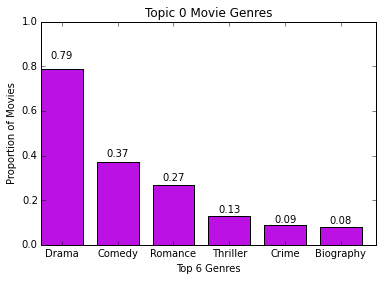

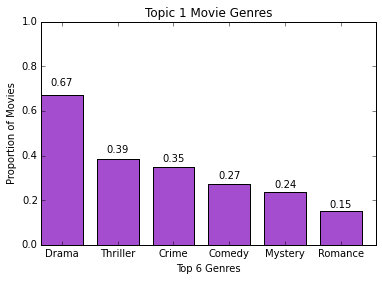

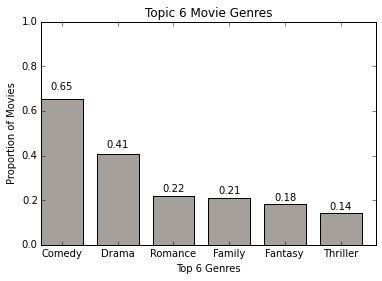

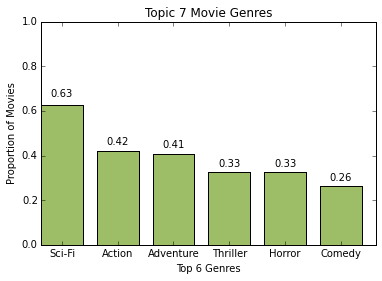

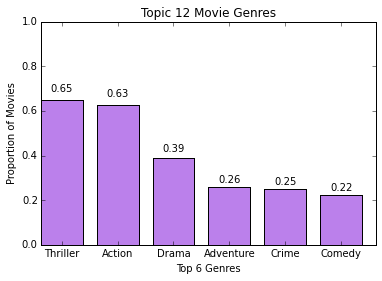

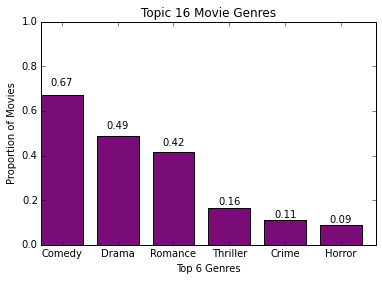

In [16]:
relevant_topics = [0, 1, 6, 7, 12, 16]

# for topic in relevant_topics:
#     print topic
#     for entry in topic_genre_movie_percs[topic]:
#         print entry
#     print

WANT_TOP = 6

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*height, '%0.2f'%height,
                ha='center', va='bottom')

for topic in relevant_topics:
    plt.figure(topic)
    percs = [x[1] for x in topic_genre_movie_percs[topic][:WANT_TOP]]
    labels = [x[0] for x in topic_genre_movie_percs[topic][:WANT_TOP]]
    n = len(percs)
    ind = np.arange(n)
    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, percs, 0.75, color=np.random.rand(3,1))
    ax.set_xticks(ind+0.375)
    ax.set_xticklabels(labels)
    ax.set_title('Topic %d Movie Genres' % topic)
    ax.set_xlabel('Top 6 Genres')
    ax.set_ylabel('Proportion of Movies')
    ax.set_ylim([0, 1])
    autolabel(rects1)
    plt.savefig("%d.png" % topic, dpi=300)